## Section 0: Team Members
- Choo Rui Bin

## Section 1: Project Title

Prediction of future housing prices in various regions in Singapore using a RNN.

## Section 2: Project Definition

### Goals

This project utilises a RNN with LSTM neurons to predict future housing prices for different regions in Singapore, and subsequently chooses the most profitable region for purchase of a HDB property.

### Dataset

The Resale Flat Prices dataset on data.gov.sg is utilised. <br>
https://data.gov.sg/dataset/resale-flat-prices?view_id=d39c48b1-19c2-4b26-a439-e9f81b573aa5&resource_id=1b702208-44bf-4829-b620-4615ee19b57c

The dataset contains resale flat prices from the year 1990 till present.

| Attribute | Description |
| --- | --- |
| Month | Month during which the flat was sold |
| Town | Ang Mo Kio, Bishan, etc. |
| Flat Type | 3 room, 4 room, etc. |
| Block | |
| Street Name | |
| Storey Range | 01-03, 04-06, 07-09, 10-12, etc. |
| Floor Area (sqm) | |
| Flat Model | Improved, New Generation, Maisonette etc. |
| Lease Commencement Date | Beginning year of flat lease |
| Resale Price \($\) | | 


### Tasks

1. Convert the dataset to a time-series format.
    - The dataset will be segregated into quarter-years and average price per sqm (resale price divided by sqm)
    - There will be 6 time-series datasets, one for each region of Singapore
2. For each dataset, split it in a 75-25 ratio and train a RNN model.
3. Then, utilise this trained model to predict the trend of the housing prices for the next 20 quarters (i.e. 5 years).
4. Repeat this train-and-predict sequence for all datasets.
5. Assess the predicted future trends for the different regions of Singapore and select the region with the greatest potential price increase.

In [1]:
# References:
# https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
# https://machinelearningmastery.com/tune-lstm-hyperparameters-keras-time-series-forecasting/
# https://www.kaggle.com/niyamatalmass/machine-learning-for-time-series-analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# pre-processing
from sklearn.preprocessing import MinMaxScaler

# model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM # for CPU
#from keras.layers import CuDNNLSTM # for GPU

# evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt # for RMSE
#from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

%matplotlib inline

Using TensorFlow backend.


In [3]:
df_data1 = pd.read_csv('./data/resale-flat-prices-based-on-approval-date-1990-1999.csv')
df_data2 = pd.read_csv('./data/resale-flat-prices-based-on-approval-date-2000-feb-2012.csv')
df_data3 = pd.read_csv('./data/resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv')
df_data4 = pd.read_csv('./data/resale-flat-prices-based-on-registration-date-from-jan-2015-onwards.csv')

print(df_data1.columns)
print(df_data2.columns)
print(df_data3.columns)
print(df_data4.columns)

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price'],
      dtype='object')
Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price'],
      dtype='object')
Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price'],
      dtype='object')
Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price'],
      dtype='object')


Drop `remaining_lease` column in the last dataset to standardise the columns across all the datasets.

In [4]:
df_data4.drop(['remaining_lease'], axis=1, inplace=True)

In [5]:
df = pd.concat([
    df_data1,
    df_data2,
    df_data3,
    df_data4
])

len(df)

785798

In [6]:
df.head(3)

month        town flat_type block       street_name storey_range  \
0  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     10 TO 12   
1  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     04 TO 06   
2  1990-01  ANG MO KIO    1 ROOM   309  ANG MO KIO AVE 1     10 TO 12   

   floor_area_sqm flat_model  lease_commence_date  resale_price  
0            31.0   IMPROVED                 1977        9000.0  
1            31.0   IMPROVED                 1977        6000.0  
2            31.0   IMPROVED                 1977        8000.0

## Section 3 & 4: Data and Feature Engineering

### Converting to time-series format

Steps:
- Restrict the town list
- Add a column `price_per_sqm`
- Filter flat types
- Drop irrelevant columns
- Convert to indexing by quarter-year
- Convert dataset to time-series format

The eventual time-series dataset will contain 2 columns:
1. Quarter
2. Average resale price (in price per sqm)

#### Restrict the town list

By default, the HDB dataset defines the following list of towns.

In [7]:
df['town'].unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG', 'CLEMENTI',
       'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
       'KALLANG/WHAMPOA', 'MARINE PARADE', 'QUEENSTOWN', 'SENGKANG',
       'SERANGOON', 'TAMPINES', 'TOA PAYOH', 'WOODLANDS', 'YISHUN',
       'LIM CHU KANG', 'SEMBAWANG', 'BUKIT PANJANG', 'PASIR RIS',
       'PUNGGOL'], dtype=object)

In [8]:
df['town'].value_counts()

TAMPINES           70341
YISHUN             60016
BEDOK              59226
JURONG WEST        57762
WOODLANDS          55626
ANG MO KIO         46540
HOUGANG            43509
BUKIT BATOK        38975
CHOA CHU KANG      31644
BUKIT MERAH        29052
PASIR RIS          28999
TOA PAYOH          27310
QUEENSTOWN         25009
CLEMENTI           24902
GEYLANG            24760
KALLANG/WHAMPOA    23064
BUKIT PANJANG      22352
JURONG EAST        21972
SENGKANG           20389
SERANGOON          20353
BISHAN             18783
SEMBAWANG           9911
PUNGGOL             9832
MARINE PARADE       7180
CENTRAL AREA        6051
BUKIT TIMAH         2176
LIM CHU KANG          64
Name: town, dtype: int64

We restructure into the following list of towns:
- NORTH (ANG MO KIO, BISHAN, TOA PAYOH)
- FAR NORTH (WOODLANDS, YISHUN, SEMBAWANG)
- NORTH EAST (HOUGANG, SENGKANG, SERANGOON, PUNGGOL)
- EAST (BEDOK, GEYLANG, KALLANG/WHAMPOA, MARINE PARADE, TAMPINES, PASIR RIS) 
- WEST (BUKIT MERAH, BUKIT TIMAH, CLEMENTI, QUEENSTOWN)
- FAR WEST (BUKIT BATOK, CHOA CHU KANG, JURONG EAST, JURONG WEST, BUKIT PANJANG) 

Notes: 
- Drop 'LIM CHU KANG' as flats are no longer being sold there.
- Drop 'CENTRAL AREA' as focus will primarily be on suburban areas.

<img src="./img/sg-regions.png">

In [9]:
# define a dict for restructuring of towns
town_dict = {
    'ANG MO KIO': 'NORTH',
    'BEDOK': 'EAST',
    'BISHAN': 'NORTH',
    'BUKIT BATOK': 'FAR WEST',
    'BUKIT MERAH': 'WEST',
    'BUKIT PANJANG': 'FAR WEST',
    'BUKIT TIMAH': 'WEST',
    'CHOA CHU KANG': 'FAR WEST',
    'CLEMENTI': 'WEST',
    'GEYLANG': 'EAST',
    'HOUGANG': 'NORTH EAST', 
    'JURONG EAST': 'FAR WEST', 
    'JURONG WEST': 'FAR WEST',
    'KALLANG/WHAMPOA': 'EAST', 
    'MARINE PARADE': 'EAST', 
    'PASIR RIS': 'EAST',
    'PUNGGOL': 'NORTH EAST',
    'QUEENSTOWN': 'WEST', 
    'SEMBAWANG': 'FAR NORTH',  
    'SENGKANG': 'NORTH EAST',
    'SERANGOON': 'NORTH EAST', 
    'TAMPINES': 'EAST', 
    'TOA PAYOH': 'NORTH', 
    'WOODLANDS': 'FAR NORTH', 
    'YISHUN': 'FAR NORTH'   
}

In [11]:
# remove LIM CHU KANG and CENTRAL AREA
df = df.loc[(df['town'] != 'LIM CHU KANG') & (df['town'] != 'CENTRAL AREA')]

df.replace({'town': town_dict}, inplace=True)

#### Add a column `price_per_sqm`

Divide `resale_price` by `floor_area_sqm` for a more representative figure.

In [12]:
df['price_per_sqm'] = df['resale_price'] / df['floor_area_sqm']

#### Filter flat types

We restrict `flat_type` to be of the following values:
- 3 ROOM
- 4 ROOM
- 5 ROOM
- EXECUTIVE

In [13]:
df = df.loc[(df.flat_type == '3 ROOM') | (df.flat_type == '4 ROOM') | (df.flat_type == '5 ROOM') | 
            (df.flat_type == 'EXECUTIVE')]

In [14]:
df['flat_type'].value_counts()

4 ROOM       290415
3 ROOM       259031
5 ROOM       160434
EXECUTIVE     59697
Name: flat_type, dtype: int64

#### Drop the irrelevant columns

Remove `flat_type`, `block`, `street_name`, `storey_range`, `floor_area_sqm`, `flat_model`, `lease_commence_date`.

Also drop `resale_price` since `price_per_sqm` is used instead.

In [15]:
df.drop(['flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price'], 
            axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

In [16]:
df.head()

month   town  price_per_sqm
0  1990-01  NORTH     646.575342
1  1990-01  NORTH     686.567164
2  1990-01  NORTH     626.865672
3  1990-01  NORTH     567.164179
4  1990-01  NORTH     597.014925

#### Convert to indexing by quarter-year

Replace the `month` column with a `quarter` column to lessen the effect of short-term fluctuations.

In [17]:
# add a 'quarter' column
df['quarter'] = pd.to_datetime(df['month'])
df['quarter'] = pd.PeriodIndex(df['quarter'], freq='Q')
df.quarter = df.quarter.astype(str)
# drop the 'month' column
df.drop('month', axis=1, inplace=True)

In [18]:
df.head()

town  price_per_sqm quarter
0  NORTH     646.575342  1990Q1
1  NORTH     686.567164  1990Q1
2  NORTH     626.865672  1990Q1
3  NORTH     567.164179  1990Q1
4  NORTH     597.014925  1990Q1

In [94]:
df['town'].value_counts()

EAST          210388
FAR WEST      172597
FAR NORTH     125212
NORTH EAST     93860
NORTH          90998
WEST           76522
Name: town, dtype: int64

#### Create datasets in time-series format

Output will be 6 datasets, one representing each region of Singapore.

In [19]:
def get_subdataset(df, town):
    return df.loc[df['town'] == town]

In [20]:
df_north = get_subdataset(df, 'NORTH')
df_farnorth = get_subdataset(df, 'FAR NORTH')
df_northeast = get_subdataset(df, 'NORTH EAST')
df_east = get_subdataset(df, 'EAST')
df_west = get_subdataset(df, 'WEST')
df_farwest = get_subdataset(df, 'FAR WEST')

For each dataset, for each quarter, get the mean of the price per sqm.

In [21]:
def convert_dataset_to_timeseries_format(df):
    df_timeseries = pd.DataFrame(columns=['quarter', 'avg_price_per_sqm'])
    
    quarters = df['quarter'].unique()
    for i in range(len(quarters)):
        df_temp = df.loc[df['quarter'] == quarters[i]]
        df_timeseries.loc[i] = [quarters[i], df_temp['price_per_sqm'].mean()]
    
    df_timeseries.sort_values(['quarter'], inplace=True)
    
    # set 'quarter' to be the index of the dataset
    df_timeseries.set_index(['quarter'], drop=True, inplace=True)
    
    return df_timeseries

In [22]:
df_north_ts = convert_dataset_to_timeseries_format(df_north)
df_farnorth_ts = convert_dataset_to_timeseries_format(df_farnorth)
df_northeast_ts = convert_dataset_to_timeseries_format(df_northeast)
df_east_ts = convert_dataset_to_timeseries_format(df_east)
df_west_ts = convert_dataset_to_timeseries_format(df_west)
df_farwest_ts = convert_dataset_to_timeseries_format(df_farwest)

In [93]:
df_east_ts.head

<bound method NDFrame.head of          avg_price_per_sqm
quarter                   
1990Q1          788.179873
1990Q2          820.321126
1990Q3          829.291975
1990Q4          826.855877
1991Q1          846.985186
1991Q2          845.817500
1991Q3          869.145457
1991Q4          861.246788
1992Q1          874.301058
1992Q2          904.174861
1992Q3          948.503364
1992Q4          951.923487
1993Q1          989.776569
1993Q2         1158.481801
1993Q3         1437.510369
1993Q4         1674.149017
1994Q1         1734.871971
1994Q2         1816.559724
1994Q3         1900.595306
1994Q4         1942.466814
1995Q1         1995.806976
1995Q2         2155.078445
1995Q3         2330.470020
1995Q4         2481.201498
1996Q1         2681.064783
1996Q2         3002.525689
1996Q3         3288.053671
1996Q4         3378.031503
1997Q1         3398.487732
1997Q2         3406.144303
...                    ...
2011Q3         4698.060794
2011Q4         4800.790768
2012Q1         4780.46449

In [24]:
def plot_price_against_time(df):
    fig, ax = plt.subplots(figsize=(16, 8))
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))    # to restrict the number of labels shown on the x-axis
    #ax.axhline(y=0, color='black', linewidth=1, linestyle='--')
    
    # if there are future predicted values, plot them in a different colour
    if len(df) > 116:
        ax.plot(df.iloc[:116, :], color='blue')
        ax.plot(df.iloc[115:, :], color='red')
    else:
        ax.plot(df)
    ax.set(xlabel='Quarter', ylabel='Price per sqm', title='Price per sqm vs. quarter')

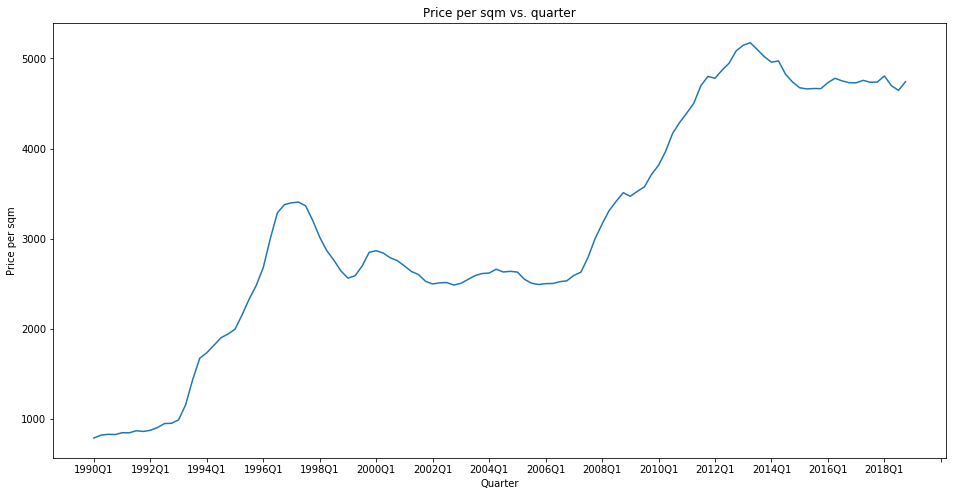

In [25]:
plot_price_against_time(df_east_ts)

## Section 5: Model Engineering

### Pre-processing for RNN

Now, the dataset has been converted into a time-series format.

Next, we do further pre-processing to prepare the dataset for a LSTM network:
1. Transform to supervised learning
2. Split into train and test sets
3. Scale the data to the range (-1, 1)

#### Transform to supervised learning

Transform dataset in time-series format to supervised learning format.

In [26]:
# copy-and-pasted helper function
def timeseries_to_supervised(series, window_size):
    """Transforms a sequence into a supervised
    learning dataset
    
    Inputs:
        series - the input sequence
        window_size - the window sizes to create
    Output:
        a supervised learning dataset, of window size as features
        and the current value as the target
    """
    result = series.copy()
    for i in range(window_size):
        # shift the series forward by 1 step each time
        # then append the shifted series to the result
        result = pd.concat([result, series.shift(-(i+1))], axis=1)

    # last window_size rows will have missing values because
    # they are shifted into the future
    result.dropna(inplace=True)
    return result

In [27]:
window_size = 2

# use diff() to transform the data to stationary
df_east_sup = timeseries_to_supervised(pd.DataFrame(df_east_ts.diff().values),
                                        window_size)
df_east_sup.head()

0          0          0
1  32.141253   8.970850  -2.436098
2   8.970850  -2.436098  20.129309
3  -2.436098  20.129309  -1.167686
4  20.129309  -1.167686  23.327957
5  -1.167686  23.327957  -7.898669

#### Train/test split

Utilise the first 75% of the dataset for training and the remaining 25% for testing.

In [28]:
train_size = int(len(df_east_sup) * 0.75)
train, test = df_east_sup[0:train_size], df_east_sup[train_size:len(df_east_sup)]

In [29]:
print('train:', len(train))
print('test:', len(test))

train: 84
test: 29


#### Scale to range (-1, 1)

To fit the default `tanh` activation function in the LSTM model.

Test data is scaled using the fit of the scaler on the training data, so as to ensure the min/max values of the test data do not influence the model.

In [30]:
# scale using MinMaxScaler to restrict the features to be between -1 and 1

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train)
train_sc = scaler.transform(train)
test_sc = scaler.transform(test)

### Train LSTM model

The LSTM layer expects input to be in a matrix with the dimensions: [samples, time steps, features].
- Samples: These are independent observations from the domain, typically rows of data.
- Time steps: These are separate time steps of a given variable for a given observation.
- Features: These are separate measures observed at the time of observation.

In [31]:
# inverts the scaling to get the original value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# trains the LSTM model with the specified hyperparameters
def fit_lstm(train_sc, batch_size, nb_epoch, neurons):
    X = train_sc[:, :-1]
    y = train_sc[:, -1]
    X_rnn = X.reshape(X.shape[0], 1, X.shape[1]) # [samples, time steps, features]
    
    model = Sequential()
    # stateful=True ensures state is maintained; used when treating consecutive batches as consecutive inputs
    model.add(LSTM(neurons,
                  batch_input_shape=(batch_size, X_rnn.shape[1], X_rnn.shape[2]),
                  stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # fit model
    # reset_states() is manually called after every epoch as the network is stateful; 
    # helps to make consecutive model calls independent
    for i in range(nb_epoch): 
        model.fit(X_rnn, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()

    return model

# given a trained model and one feature row, output a prediction 
# reset_states() is not called as the model should build up state following each prediction
def predict_lstm(model, batch_size, X_test_sc):
    X_test_rnn = X_test_sc.reshape(1, 1, len(X_test_sc))
    yhat = model.predict(X_test_rnn, batch_size=batch_size)
    return yhat[0,0]

Variables for reference:
- `df_east_ts` - quarter, avg_price_per_sqm
- `df_east_sup` - above time-series data, converted to supervised learning with a window size of 5
- `train`, `test` - divided in a 75-25 split
- `train_sc`, `test_sc` - scaled versions of the above (`scaler` for scaler)

The output results of a LSTM network, or neural networks in general, are greatly affected by the random initial conditions.

To control this, run each fit-and-predict sequence multiple times.

Evaluate each generated model on the test set using walk-forward model validation and save the root mean squared error (RMSE) score.

In [45]:
# hyperparameters
repeats = 10
batch_size = 1
n_epoch = 500
n_neurons = 2

error_scores = list()
predictions_full = list()
models_full = list()

for i in range(repeats):
    model = fit_lstm(train_sc, batch_size, n_epoch, n_neurons)
    predictions = list()
    
    # walk-forward model validation
    # (use model to make a forecast for this time step, but use the actual value from the test set to make the forecast
    # for the next time step instead of using the previous forecast)
    for j in range(len(test_sc)):
        X_test_sc = test_sc[j, :-1]
        y_test_sc = test_sc[j, -1]
        yhat = predict_lstm(model, batch_size, X_test_sc)
        
        yhat = invert_scale(scaler, X_test_sc, yhat)
        
        predictions.append(yhat)

    # error on the 1st order diff
    rmse = sqrt(mean_squared_error(df_east_sup.iloc[train_size:len(df_east_sup), -1], predictions))
    print('%d) Test RMSE: %.3f' % (i+1, rmse))
    error_scores.append(rmse)
    
    models_full.append(model)
    predictions_full.append(predictions)

1) Test RMSE: 84.751
2) Test RMSE: 75.750
3) Test RMSE: 76.174
4) Test RMSE: 75.101
5) Test RMSE: 73.374
6) Test RMSE: 78.553
7) Test RMSE: 88.740
8) Test RMSE: 77.017
9) Test RMSE: 80.354
10) Test RMSE: 76.996


The average RMSE across all the repeats are taken as an indication of how well the configuration would be expected to perform on unseen data on average.

            rmse
count  10.000000
mean   78.680916
std     4.741112
min    73.374035
25%    75.855658
50%    77.006365
75%    79.903951
max    88.739848


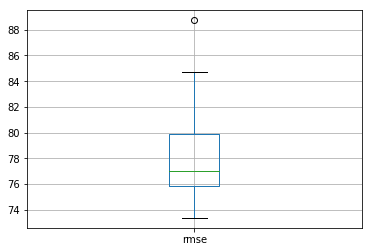

In [46]:
# summarise results
results = pd.DataFrame()
results['rmse'] = error_scores
print(results.describe())

# visualise results
results.boxplot()
plt.show()

Choose the run that resulted in the lowest RMSE and utilise that model and prediction as the preferred.

In [47]:
best_run_index = np.argmin(error_scores)
print('Best run index:', best_run_index)

model_best = models_full[best_run_index]
prediction_best = predictions_full[best_run_index]

Best run index: 4


In [33]:
"""
import time

es = EarlyStopping(patience=5, monitor='mean_absolute_error')
tb = TensorBoard(log_dir='./logs/rnn/{}'.format(int(time.time())))
mc = ModelCheckpoint('./model_lstm/rnn_weights.{epoch:02d}.hdf5')

model.compile(loss='mean_squared_error', optimizer='adam',
              metrics=['mae'])

# note: validation and training sizes need to be divisible
# by batch_size for training RNNs
model.fit(X_train_rnn, y_train_sc, epochs=100, 
          batch_size=batch_size,
          callbacks=[es, tb, mc],
          shuffle=False)
"""

"\nimport time\n\nes = EarlyStopping(patience=5, monitor='mean_absolute_error')\ntb = TensorBoard(log_dir='./logs/rnn/{}'.format(int(time.time())))\nmc = ModelCheckpoint('./model_lstm/rnn_weights.{epoch:02d}.hdf5')\n\nmodel.compile(loss='mean_squared_error', optimizer='adam',\n              metrics=['mae'])\n\n# note: validation and training sizes need to be divisible\n# by batch_size for training RNNs\nmodel.fit(X_train_rnn, y_train_sc, epochs=100, \n          batch_size=batch_size,\n          callbacks=[es, tb, mc],\n          shuffle=False)\n"

#### Compare against validation set

Compare the predicted results with the actual results.

In [48]:
y_test = test.iloc[:, -1].values
y_pred = prediction_best

test_start_index = test.index[0] # start of test data
test_end_index = test.index[-1] # end of test data
train_end_index = test_start_index-1 # end of training data
# last value of training data
test_start_value = df_east_ts.iloc[train_end_index]['avg_price_per_sqm']

# compute the predictions using cumulative sum
df_reconstructed = pd.DataFrame({'predictions': [test_start_value] + y_pred}).cumsum()
df_reconstructed['truth'] = df_east_ts.iloc[train_end_index:test_end_index+1].values
# predictions for 1st order difference
df_diff_reconstructed = pd.DataFrame({'predictions': y_pred})
df_diff_reconstructed['truth'] = y_test

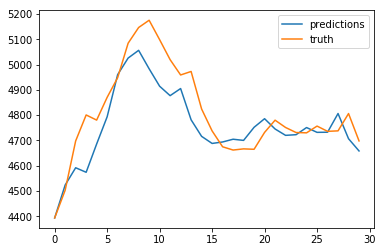

In [49]:
df_reconstructed.plot()

## Predict for future quarters

Finally, we utilise the model to predict the subsequent quarters.

Define number of quarters to predict as 20.

In [50]:
# define the next 20 quarters
qtr_future = ['2019Q1', '2019Q2', '2019Q3', '2019Q4',
              '2020Q1', '2020Q2', '2020Q3', '2020Q4',
              '2021Q1', '2021Q2', '2021Q3', '2021Q4',
              '2022Q1', '2022Q2', '2022Q3', '2022Q4',
              '2023Q1', '2023Q2', '2023Q3', '2023Q4',
             ]

In [55]:
# use last value of dataset as a base to perform further predictions on
last_value = test_sc[len(test_sc)-1, 1:]

pred_sc = list() # nx3-array
pred_sc.append(last_value)
pred_future = list() # nx1-array

# predict for next 20 quarters
for i in range(20): 
    yhat = predict_lstm(model, 1, pred_sc[i])
    
    # invert the scaling of the prediction and store separately
    yhat_inv = invert_scale(scaler, pred_sc[i], yhat)
    pred_future.append(yhat_inv)
    
    # populate the scaled table to facilitate further predictions
    pred_sc[i] = np.append(pred_sc[i], yhat)
    pred_sc.append(pred_sc[i][len(pred_sc[i])-2:len(pred_sc[i])])

In [56]:
pred_future

[239.09222549863102,
 304.36482647541635,
 194.71255477784229,
 70.18669064776334,
 40.496500411522064,
 24.816398274830085,
 18.726193229643815,
 9.769162915754402,
 -4.374439394135939,
 -25.63390695479357,
 -45.84749040933941,
 -53.996932208419906,
 -49.344827305709735,
 -35.757906471210816,
 -16.89505469328687,
 2.616040712243713,
 16.69094861619894,
 20.33605977598929,
 14.217121901423836,
 4.869372210976494]

Combine the predictions for the future with the existing dataset to witness the long-term trend.

In [57]:
df_future = pd.DataFrame({'avg_price_per_sqm': [df_east_ts.tail(1).values[0][0]] + pred_future}).cumsum()

# remove the 1st element, which is the last element of the original dataset
df_future.drop(0, inplace=True)
# set index to be the quarter, in accordance with the original df
df_future['quarter'] = qtr_future
df_future.set_index('quarter', drop=True, inplace=True)

In [58]:
df_comb = pd.concat([
    df_east_ts,
    df_future
])

df_comb

avg_price_per_sqm
quarter                   
1990Q1          788.179873
1990Q2          820.321126
1990Q3          829.291975
1990Q4          826.855877
1991Q1          846.985186
1991Q2          845.817500
1991Q3          869.145457
1991Q4          861.246788
1992Q1          874.301058
1992Q2          904.174861
1992Q3          948.503364
1992Q4          951.923487
1993Q1          989.776569
1993Q2         1158.481801
1993Q3         1437.510369
1993Q4         1674.149017
1994Q1         1734.871971
1994Q2         1816.559724
1994Q3         1900.595306
1994Q4         1942.466814
1995Q1         1995.806976
1995Q2         2155.078445
1995Q3         2330.470020
1995Q4         2481.201498
1996Q1         2681.064783
1996Q2         3002.525689
1996Q3         3288.053671
1996Q4         3378.031503
1997Q1         3398.487732
1997Q2         3406.144303
...                    ...
2016Q3         4751.316369
2016Q4         4731.384558
2017Q1         4730.122017
2017Q2         4756.796605
2017Q3         4736.022829
2017Q4         4737.925176
2018Q1         4806.346918
2018Q2         4698.161881
2018Q3         4645.669942
2018Q4         4742.574425
2019Q1         4981.666650
2019Q2         5286.031477
2019Q3         5480.744031
2019Q4         5550.930722
2020Q1         5591.427222
2020Q2         5616.243621
2020Q3         5634.969814
2020Q4         5644.738977
2021Q1         5640.364538
2021Q2         5614.730631
2021Q3         5568.883140
2021Q4         5514.886208
2022Q1         5465.541381
2022Q2         5429.783474
2022Q3         5412.888419
2022Q4         5415.504460
2023Q1         5432.195409
2023Q2         5452.531469
2023Q3         5466.748590
2023Q4         5471.617963

[136 rows x 1 columns]

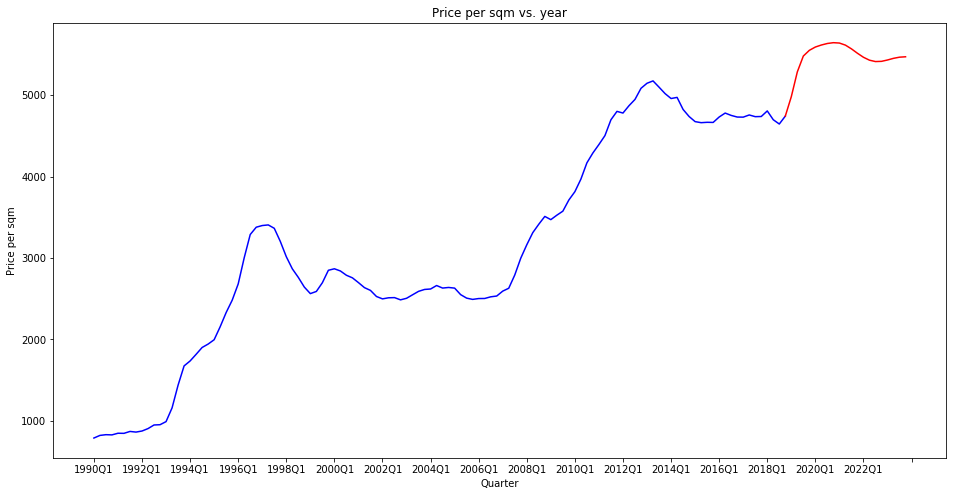

In [111]:
plot_price_against_time(df_comb)

In [61]:
pickle.dump(scaler, open('./output/scaler_east.pk', 'wb'))
pickle.dump(model_best, open('./output/model_east.pk', 'wb'))
pickle.dump(pred_future, open('./output/pred_east.pk', 'wb'))

### Repeat train-and-predict sequence for the other datasets

Utilise external helper class for brevity.

In [34]:
# import helper class
from scripts import helpers

In [35]:
# for refreshing of edited package
import importlib
importlib.reload(helpers)

<module 'scripts.helpers' from 'C:\\Users\\Ruibin\\Documents\\Machine Learning\\MLDDS Course\\notebooks\\project\\scripts\\helpers.py'>

In [36]:
scaler_north, model_north, df_north_reconstructed, last_value = helpers.train(df_north_ts)
pred_north = helpers.forecast(scaler_north, model_north, last_value)

pickle.dump(scaler_north, open('./output/scaler_north.pk', 'wb'))
pickle.dump(model_north, open('./output/model_north.pk', 'wb'))
pickle.dump(pred_north, open('./output/pred_north.pk', 'wb'))

In [37]:
scaler_farnorth, model_farnorth, df_farnorth_reconstructed, last_value = helpers.train(df_farnorth_ts)
pred_farnorth = helpers.forecast(scaler_farnorth, model_farnorth, last_value)

pickle.dump(scaler_farnorth, open('./output/scaler_farnorth.pk', 'wb'))
pickle.dump(model_farnorth, open('./output/model_farnorth.pk', 'wb'))
pickle.dump(pred_farnorth, open('./output/pred_farnorth.pk', 'wb'))

In [38]:
scaler_northeast, model_northeast, df_northeast_reconstructed, last_value = helpers.train(df_northeast_ts)
pred_northeast = helpers.forecast(scaler_northeast, model_northeast, last_value)

pickle.dump(scaler_northeast, open('./output/scaler_northeast.pk', 'wb'))
pickle.dump(model_northeast, open('./output/model_northeast.pk', 'wb'))
pickle.dump(pred_northeast, open('./output/pred_northeast.pk', 'wb'))

In [39]:
scaler_west, model_west, df_west_reconstructed, last_value = helpers.train(df_west_ts)
pred_west = helpers.forecast(scaler_west, model_west, last_value)

pickle.dump(scaler_west, open('./output/scaler_west.pk', 'wb'))
pickle.dump(model_west, open('./output/model_west.pk', 'wb'))
pickle.dump(pred_west, open('./output/pred_west.pk', 'wb'))

In [40]:
scaler_farwest, model_farwest, df_farwest_reconstructed, last_value = helpers.train(df_farwest_ts)
pred_farwest = helpers.forecast(scaler_farwest, model_farwest, last_value)

pickle.dump(scaler_farwest, open('./output/scaler_farwest.pk', 'wb'))
pickle.dump(model_farwest, open('./output/model_farwest.pk', 'wb'))
pickle.dump(pred_farwest, open('./output/pred_farwest.pk', 'wb'))

## Final Analysis and Conclusion

By examining the future predicted trends, we can make a conclusion on the region in Singapore where the largest increase in housing prices will be observed in the next 5 years.

#### North region

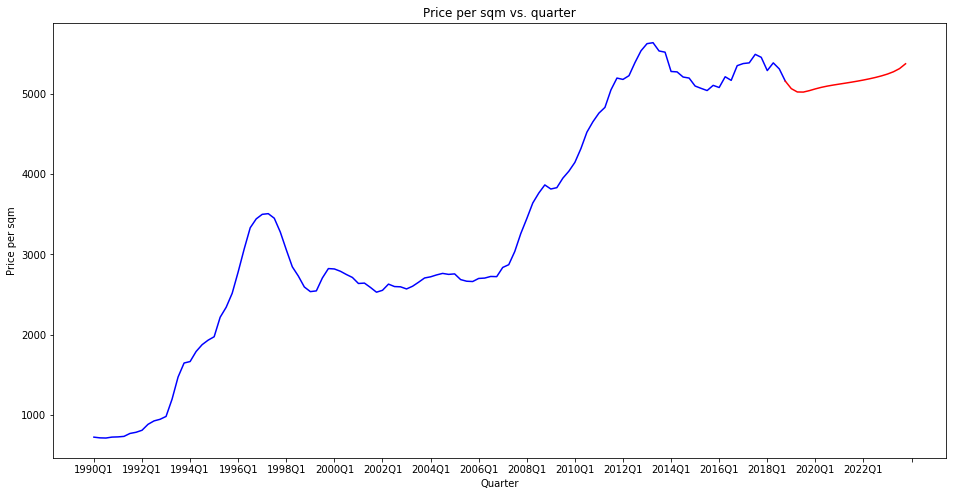

In [42]:
pred_north = pickle.load(open('./output/pred_north.pk', 'rb'))
avg_pred_price_pct_change_north = helpers.plot_present_with_forecast(df_north_ts, pred_north)

#### Far North region

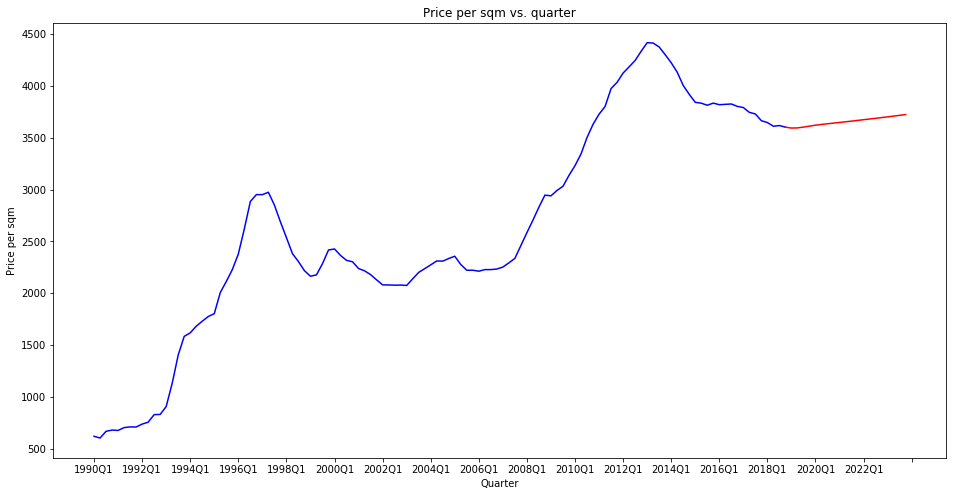

In [43]:
pred_farnorth = pickle.load(open('./output/pred_farnorth.pk', 'rb'))
avg_pred_price_pct_change_farnorth = helpers.plot_present_with_forecast(df_farnorth_ts, pred_farnorth)

#### North East region

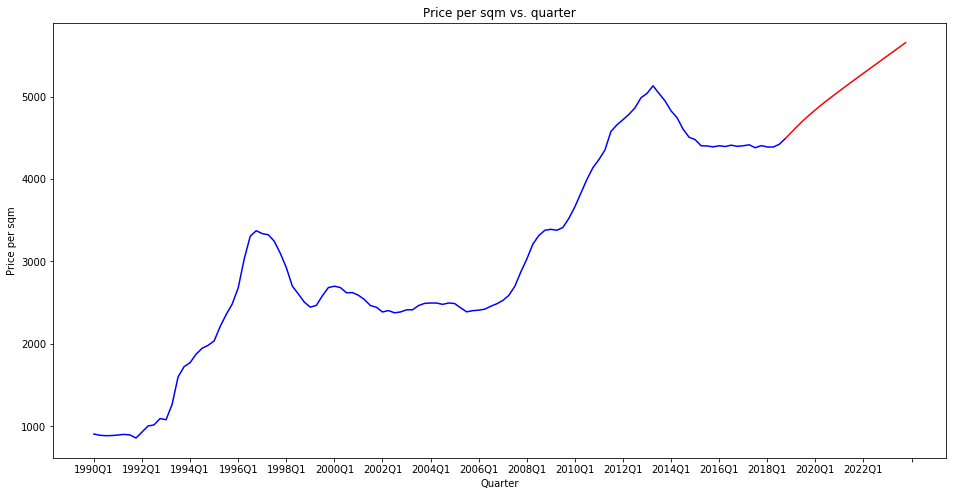

In [83]:
pred_northeast = pickle.load(open('./output/pred_northeast.pk', 'rb'))
avg_pred_price_pct_change_northeast = helpers.plot_present_with_forecast(df_northeast_ts, pred_northeast)

#### East region

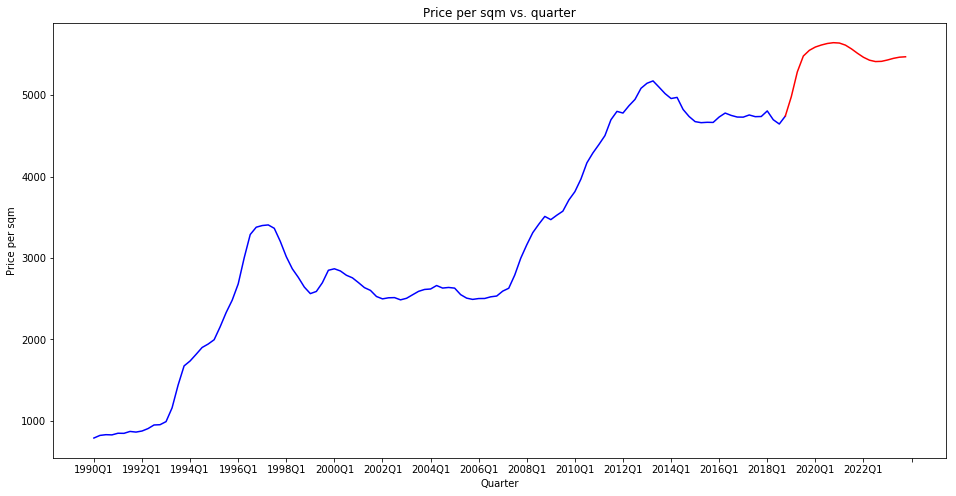

In [45]:
pred_east = pickle.load(open('./output/pred_east.pk', 'rb'))
avg_pred_price_pct_change_east = helpers.plot_present_with_forecast(df_east_ts, pred_east)

#### West region

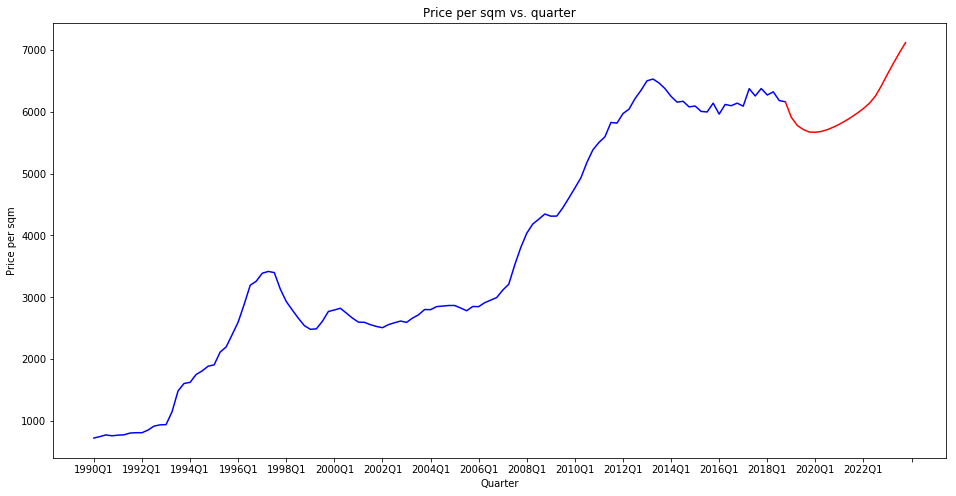

In [47]:
pred_west = pickle.load(open('./output/pred_west.pk', 'rb'))
avg_pred_price_pct_change_west = helpers.plot_present_with_forecast(df_west_ts, pred_west)

#### Far West region

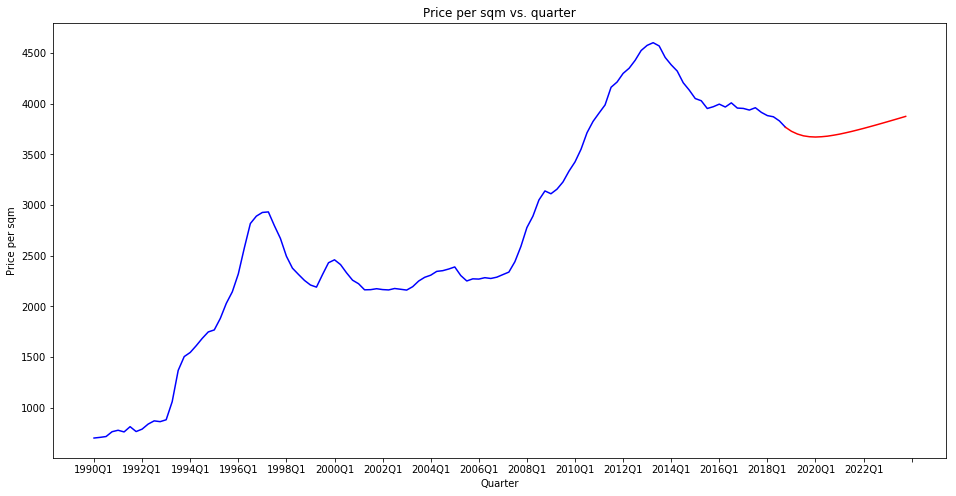

In [48]:
pred_farwest = pickle.load(open('./output/pred_farwest.pk', 'rb'))
avg_pred_price_pct_change_farwest = helpers.plot_present_with_forecast(df_farwest_ts, pred_farwest)

#### Summary

Examine the average predicted percentage change in price for the different regions and then select the region with the highest value.

In [84]:
df_summary = pd.DataFrame({
    'region': 
         ['north', 'farnorth', 'northeast', 'east', 'west', 'farwest'],
    'avg_price_pct_change': [
            avg_pred_price_pct_change_north,
            avg_pred_price_pct_change_farnorth,
            avg_pred_price_pct_change_northeast,
            avg_pred_price_pct_change_east,
            avg_pred_price_pct_change_west,
            avg_pred_price_pct_change_farwest,
        ]
    }
)

In [85]:
df_summary.sort_values(['avg_price_pct_change'], ascending=False, inplace=True)

df_summary

region  avg_price_pct_change
2  northeast              0.011320
4       west              0.009916
3       east              0.005082
0      north              0.003137
5    farwest              0.002042
1   farnorth              0.001878

Seems like the <b>North East region</b> is the most profitable area to purchase a HDB property in (although based on the graph, it seems more like a badly trained neural network...)

## Section 7: Observations and Analysis

Possible further improvements:
- Further tweaking of the neural network
    - Utilising callbacks (early stopping)
    - Optimising the choice of hyperparameters (batch size, number of neurons, number of epochs)
- Utilise a sliding window for train-test split

Alternative analysis:
- Segregate into Old Towns and New Towns instead of region
- Use the entire dataset of Singapore flats